# Load Libraries and set global variables

In [1]:
%load_ext autoreload
%autoreload 2
import torch
import pandas as pd
import numpy as np
import utils

from gluonts.dataset.pandas import PandasDataset
from huggingface_hub import hf_hub_download

from uni2ts.model.moirai import MoiraiForecast


TIME_COL = "year_month"
TARGET = "sales"
DYNAMIC_COV = ["Consumer_price_index", 'Consumer_confidence_index', 'Producer_price_index',
               'Fuel_retail_price', 'Vehicle_price', 'Baidu_data', 'month_1',
               'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
               'month_8', 'month_9', 'month_10', 'month_11', 'month_12']
FORECAST_HORIZON = 8 # months
FREQ = "M"

# Load Data

In [4]:
# load data and exogenous features
df = pd.read_csv('input_data_and_results/data.csv', parse_dates=[TIME_COL])

# one hot encode month
df['month'] = df[TIME_COL].dt.month
df = pd.get_dummies(df, columns=['month'], dtype=int)

print(f"Distinct number of time series: {len(df['Car_category'].unique())}")
print(f"Months: {len(df['year_month'].unique())}")
df.head()

Distinct number of time series: 2
Months: 60


,year_month,Car_category,sales,Consumer_price_index,Consumer_confidence_index,Producer_price_index,Fuel_retail_price,Vehicle_price,Baidu_data,month_1,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2011-01-01,BEV,588,104.9,99.9,106.6,100.2,101.28,1.661,1,...,0,0,0,0,0,0,0,0,0,0
1,2011-02-01,BEV,47,104.9,99.6,107.2,100.8,102.01,2.208,0,...,0,0,0,0,0,0,0,0,0,0
2,2011-03-01,BEV,159,105.4,107.6,107.3,99.7,101.89,2.592,0,...,1,0,0,0,0,0,0,0,0,0
3,2011-04-01,BEV,173,105.3,106.6,106.8,103.2,101.70,4.502,0,...,0,1,0,0,0,0,0,0,0,0
4,2011-05-01,BEV,305,105.5,105.8,106.8,101.0,101.63,2.484,0,...,0,0,1,0,0,0,0,0,0,0


# Split data between train and test

In [5]:
# 8 months to for test
train = df[df[TIME_COL] <= (max(df[TIME_COL])-pd.DateOffset(months=FORECAST_HORIZON))]
test = df[df[TIME_COL] > (max(df[TIME_COL])-pd.DateOffset(months=FORECAST_HORIZON))]

print(f"Months for training: {len(train[TIME_COL].unique())} from {min(train[TIME_COL]).date()} to {max(train[TIME_COL]).date()}")
print(f"Months for testing: {len(test[TIME_COL].unique())} from {min(test[TIME_COL]).date()} to {max(test[TIME_COL]).date()}")

Months for training: 52 from 2011-01-01 to 2015-04-01
Months for testing: 8 from 2015-05-01 to 2015-12-01


# Forecast

### Dataset Preprocessing
 - Scaling is handled internally

In [72]:
# create GluonTS dataset from pandas
ds = PandasDataset.from_long_dataframe(
    pd.concat([train, test[["Car_category", TIME_COL]+DYNAMIC_COV]]).set_index(TIME_COL), # concatenaation with test dynamic covaraiates
    item_id="Car_category",
    feat_dynamic_real=DYNAMIC_COV,
    target=TARGET,
    freq=FREQ
)

## MOIRAI

In [73]:
# Prepare pre-trained model by downloading model weights from huggingface hub
model = MoiraiForecast.load_from_checkpoint(
    checkpoint_path=hf_hub_download(
        repo_id=f"Salesforce/moirai-R-large", filename="model.ckpt"
    ),
    prediction_length=FORECAST_HORIZON,
    context_length=512,
    patch_size='auto',
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=ds.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
    map_location="cuda:0" if torch.cuda.is_available() else "cpu",
)

predictor = model.create_predictor(batch_size=32)
forecasts = predictor.predict(ds)

# convert forecast into pandas
forecast_df = utils.moirai_forecast_to_pandas(forecasts, test, FORECAST_HORIZON, TIME_COL)

## Plot Actuals and Forecast

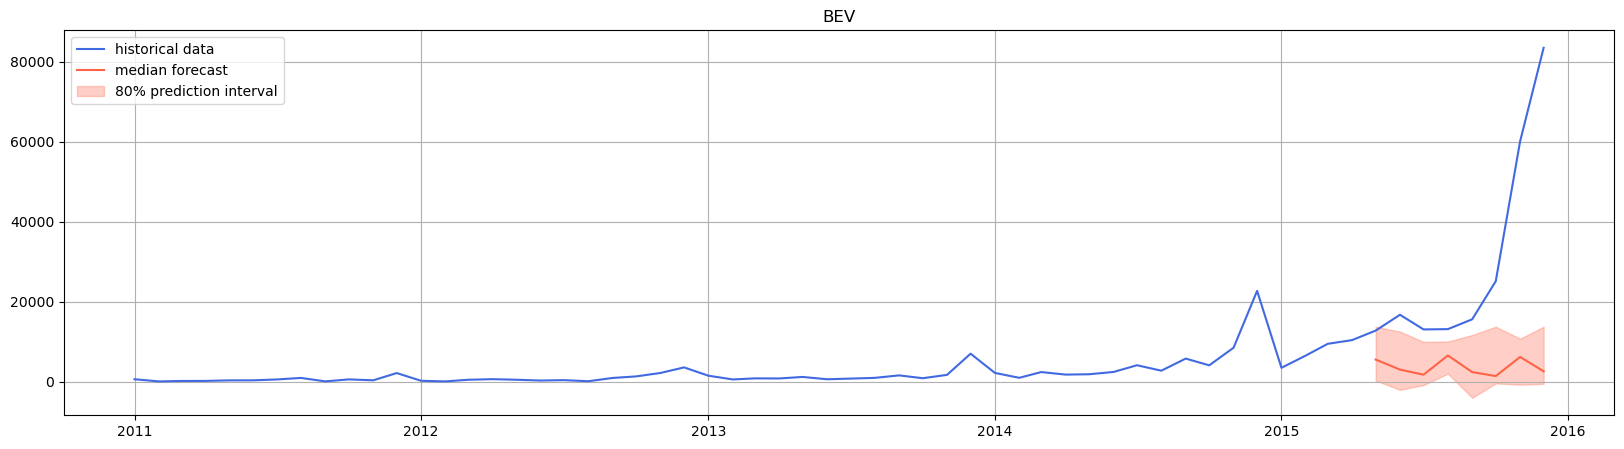

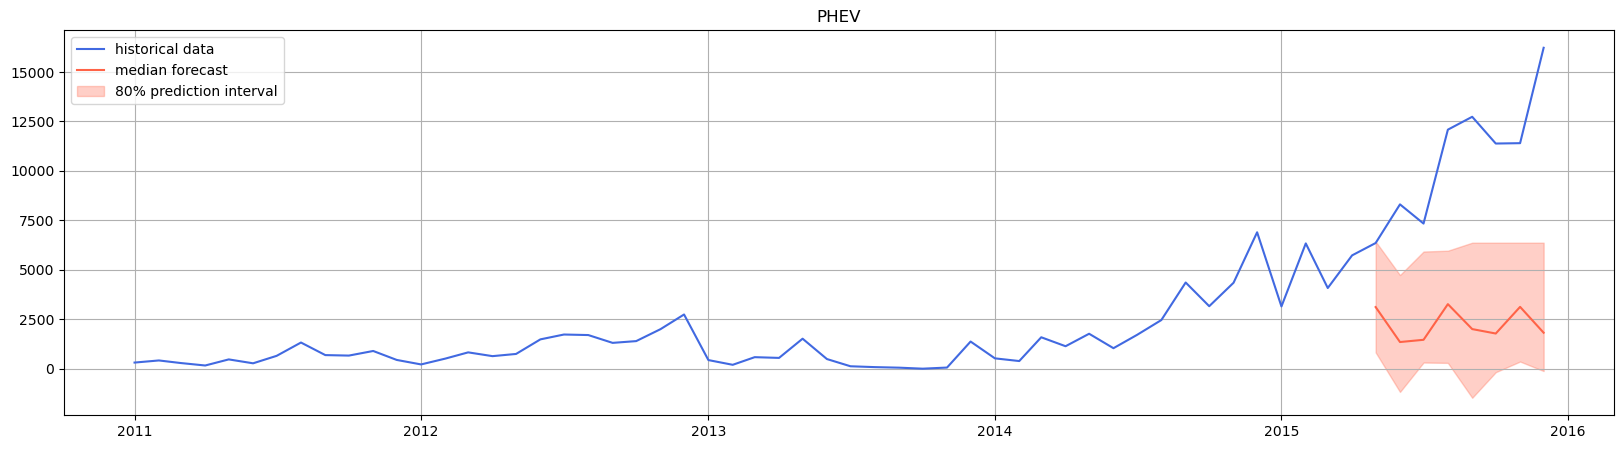

In [75]:
# get series ordered by volume in a descending way
for ts in test['Car_category'].unique():
    utils.plot_actuals_forecast(df[df["Car_category"]==ts], forecast_df[forecast_df["Car_category"] == ts], ts)

# Model Evaluation

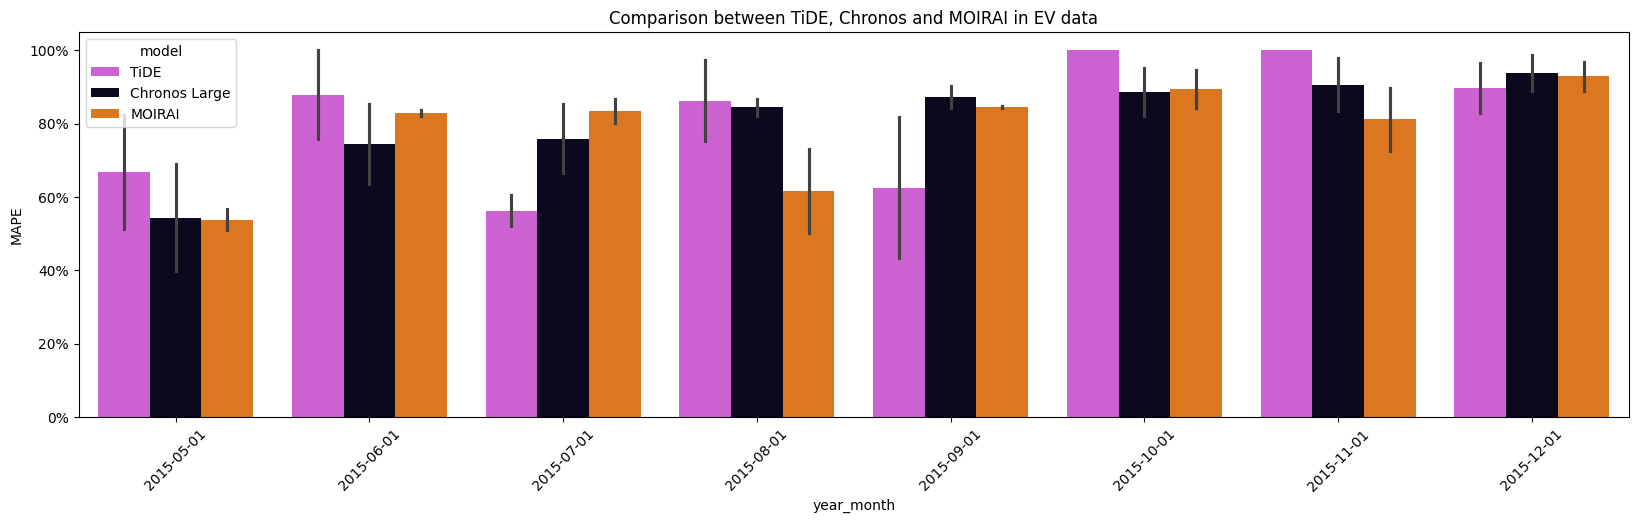

In [7]:
# load the forecast from our current model in production
tide_model_df = pd.read_csv('input_data_and_results/tide.csv', parse_dates=[TIME_COL])
chronos_large_df = pd.read_csv('input_data_and_results/chronos_large.csv', parse_dates=[TIME_COL])
moirai_df = pd.read_csv('input_data_and_results/moirai.csv', parse_dates=[TIME_COL])

# merge data frames with forecast and actuals
model_eval_df = pd.merge(test[['Car_category', TIME_COL, TARGET]], tide_model_df[['Car_category', TIME_COL, 'TiDE']], on=['Car_category', TIME_COL], how='inner')
model_eval_df = pd.merge(model_eval_df, chronos_large_df[['Car_category', TIME_COL, 'Chronos Large']], on=['Car_category', TIME_COL], how='inner')
model_eval_df = pd.merge(model_eval_df, moirai_df[['Car_category', TIME_COL, 'MOIRAI']], on=['Car_category', TIME_COL], how='inner')

utils.plot_model_comparison(model_eval_df)